In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import xarray as xr 
from sklearn.preprocessing import StandardScaler
import datetime
import tools
from tools import *


## Input data, Area Selection, Mask and Subsampling

In [ ]:
lat_min ,lat_max, lon_min , lon_max, extra = 32, 42, 360-128,360-116, 1

l3 = xr.open_dataset('~/Documents/OK-ST-package/sample_data/L3_CALIFORNIA_2018_all_missions.nc').rename({'sla_filtered':'resid'})
l3 = select_data_xarray(l3,lat_min-extra, lat_max+extra, lon_min-extra, lon_max+extra, 2018, 2018).to_dataframe().dropna()

grid = xr.open_dataset("~/Documents/OK-ST-package/sample_data/DUACS_GRID_CALIFORNIA_2018.nc")
grid = select_data_xarray(grid,lat_min, lat_max, lon_min-360, lon_max-360, 2018, 2018)

# build land mask from cmems grid own grid can be inlcuded: add mask for land if possible otherwise 
# only works when 'sla' is given e.g. when supplying cmems gridded data as grid 
grid['mask'] = np.invert(np.isnan(grid['sla']))    
grid=grid.to_dataframe().reset_index()
grid['land'] =1
grid['land'][grid['mask'].values==False]=np.nan

l3         = l3[['longitude','latitude','resid']].dropna()
l3         = l3[::10]
l3['time'] = l3.index;

## Select Window and Scale:

Processing time: 2018-05-05 00:00:00
Making temporal matrix...
Making distance matrix...
Making value matrix...
Fitting Results for time 2018-05-05 00:00:00:
  MAE: 0.1132, RMSE: 0.1572, R^2: 0.4383
2018-05-05 00:00:00
Preparing...


  0%|          | 0/1920 [00:00<?, ?it/s]

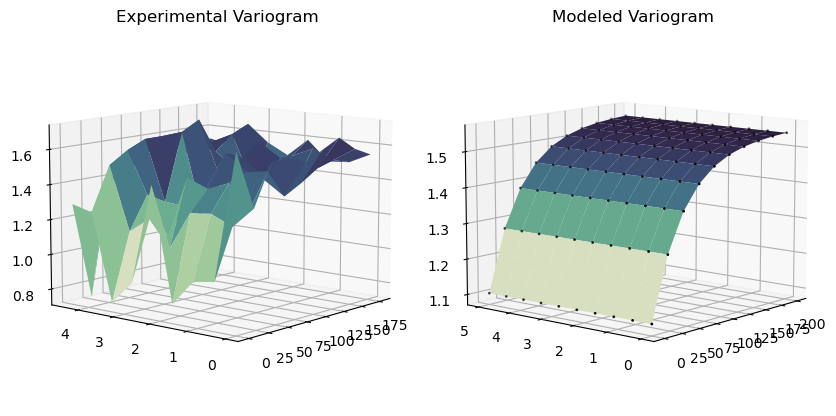

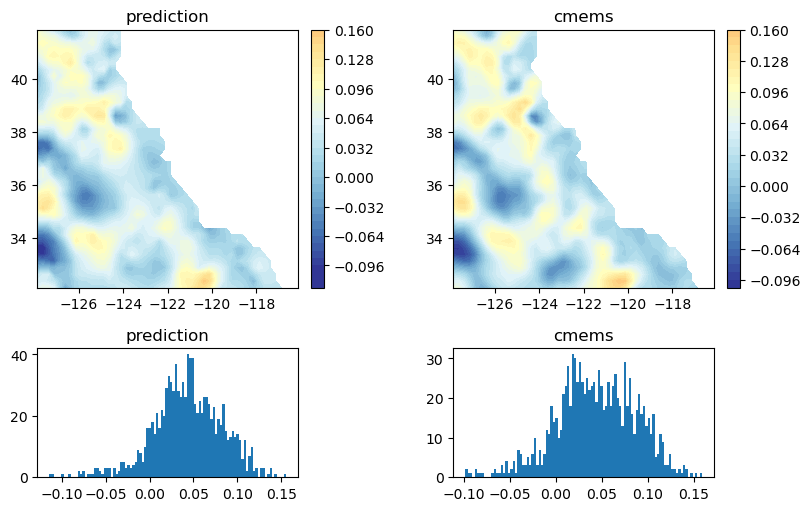

In [25]:
# Define the time period of Kriging:
start_date = pd.to_datetime(datetime.date(2018,5,5))
end_date   = pd.to_datetime(datetime.date(2018,5,5))
run_time   = pd.date_range(start=start_date, end=end_date)

import importlib
importlib.reload(tools)

'''
Input parameters: 

l3 (DataFrame)      : DataFrame containing residual data with a time index. 'latitude', 'longitude' and 'resid' needs to be given.  
grid (DataFrame)    : 
hs/ht range (tuple) :      
estimator (str)     : Kind of estimation of the esxperimental variogram in space-time. Choose between 'matheron' or 'cressie'. Default is #matheron'.
func (callable)     : Function of building the space-time variogram model. 'sum-metric' tested and implememted.
plot (bool)         : Whether to plot the experimental and modeled variograms.
exact (bool)        : Controlls smoothness of the prediction. True (default) sets diagonal of the Kriging matrix to zero, smoothing the result, allwing more deviation from the observations. 

Kriging (optional): 

  - if Kriging = False --> function returns 2 parameters (paras and fitting quality)
  - if Kriging = True  --> Function returns dataframe given as grid, added OK-ST and OK-ST-error

Saving Grid (optional):

    a valid path for 'save_as_csv    = /.../...' for save as CSV
    a valid path for 'save_as_netcdf = /.../...' for save as NETCDF 


'''
for xtime in run_time:
  df = fit_empirical_variogram( xtime      = xtime,
                                l3         = l3,    
                                grid       = grid,
                                n_days     = 5, 
                                hs_range   = (0,200,10),
                                ht_range   = (0,5,10), 
                                estimator  = 'matheron', 
                                func       = sum_metric_model, 
                                plot       = True, 
                                Kriging    = True,
                                exact      = False)
  


  #### Build xarray and make a daily test plot for checking the results:
  ds = df.set_index(['time','latitude','longitude']).to_xarray()

  fig,axis = plt.subplot_mosaic("""AB
                                  AB
                                  CD""", figsize=(8,5), layout='constrained',gridspec_kw={'hspace': 0.1, 'wspace': 0.1}, )   

  a1 = axis['A'].contourf(ds.longitude,ds.latitude,ds.OK_ST[0,:,:],levels=40,cmap='RdYlBu_r', vmin=-0.1, vmax=0.3);
  plt.colorbar(a1, ax=axis['A']);axis['A'].set_title('prediction');
  a2 = axis['B'].contourf(ds.longitude,ds.latitude,ds.sla[0,:,:],levels = 40,cmap='RdYlBu_r', vmin=-0.1, vmax=0.3);
  plt.colorbar(a2, ax=axis['B']);axis['B'].set_title('cmems');

  axis['C'].hist(ds.OK_ST[0,:,:].values.flatten(), bins=100);
  axis['C'].set_title('prediction')
  axis['D'].hist(ds.sla[0,:,:].values.flatten(), bins=100);
  axis['D'].set_title('cmems');
  plt.show()


## build requirements.txt

In [23]:
import sys
import importlib

# Get the list of used packages (filtering out internal modules)
used_packages = [name for name, module in sys.modules.items() if name in globals()]

print("Used packages and their versions in this notebook:")
for package in used_packages:
    try:
        # Import the module dynamically to check for version
        mod = importlib.import_module(package)
        version = getattr(mod, '__version__', 'No version attribute')
        print(f"{package}: {version}")
    except ModuleNotFoundError:
        print(f"{package}: Module not found")
    except Exception as e:
        print(f"{package}: Error retrieving version - {e}")

Used packages and their versions in this notebook:
sys: No version attribute
importlib: No version attribute
datetime: No version attribute
pkg_resources: No version attribute
scipy: 1.10.1
haversine: No version attribute
tqdm: 4.64.1
tools: No version attribute
